<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_JPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-im8kw0hh
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-im8kw0hh
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.04c42ce20a2fbc4b0aad83bfa86ba776b05826847_-cp36-none-any.whl size=119801 sha256=e78e2ec2e7a1fc82b4b1d0585d6f3a345ab7d8e0e672133b9000a19b4b7e205f
  Stored in directory: /tmp/pip-ephem-wheel-cache-bjvn2dm0/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/JPM/df_JPM_20drtn_features.csv')

In [6]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,17.872165,26.484143,29.618884,45.453380,-97.023039,-97.023039,-97.390304,-98.187830,24.328831,28.858183,36.763200,51.288465,-3.536403,-6.152689,-11.946277,-13.234272,-14.524250,-0.467894,-0.170772,-0.053154,-0.002631,-1.252433,-1.252433,-1.252433,-1.252433,-116.161655,-119.292805,-163.722650,-226.013029,-44.813871,-50.552737,0.203702,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.357983,0.020831,0.348288,-0.026282,0.529884,0.002480,27.549999,2.949999,4.019999,-3.837864e+07,-3.837864e+07,-3.837864e+07,-3.837864e+07,-0.031547,0.022689,0.055126,0.060690,0.221092,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,20.205073,23.150165,30.936135,47.491914,-88.020167,-88.020167,-88.622743,-92.507881,25.889804,36.018188,36.738484,53.473976,0.508436,-4.159217,-7.601476,-14.500339,-16.736864,-0.565208,-0.227102,-0.086409,-0.007954,-1.429008,-1.429008,-1.429008,-1.429008,-76.048896,-92.640680,-124.789079,-185.946352,-56.165773,-57.988816,0.384616,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.324865,-0.035161,0.319990,-0.075850,0.528707,-0.002509,27.490000,-0.059999,0.949999,-2.284601e+07,-2.284601e+07,-2.284601e+07,-2.284601e+07,-0.130891,0.052333,0.006329,0.034637,-0.024758,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,10.283311,23.714453,22.625786,45.583514,-97.934409,-97.934409,-97.934409,-98.690307,17.534411,35.550760,36.237881,51.081709,-2.875404,-5.833769,-8.387745,-17.147398,-16.750343,-0.663149,-0.286849,-0.122761,-0.014326,-1.637219,-1.637219,-1.637219,-1.637219,-96.967419,-96.186621,-121.531782,-175.943814,-69.852317,-67.958183,0.087179,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.314911,-0.035235,0.320119,-0.066532,0.528160,-0.005209,29.379999,1.889999,3.099998,-3.009196e+07,-3.009196e+07,-3.009196e+07,-3.009196e+07,-0.249117,-0.066309,-0.031016,0.001661,-0.045711,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,29.350973,34.427779,35.721799,47.265968,-69.070921,-69.258822,-69.258822,-80.508483,23.193177,38.719231,42.553309,51.584726,6.469300,3.933640,-0.893081,-11.161942,-10.403687,-0.716941,-0.335384,-0.155744,-0.020924,-1.593428,-1.593428,-1.593428,-1.593428,60.085723,-43.845094,-69.786323,-112.779419,-78.347465,-73.138651,0.800001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.524112,0.171796,0.412977,0.045091,0.553868,0.022049,26.360001,-3.019999,0.840000,2.588098e+07,2.588098e+07,2.588098e+07,2.588098e+07,-0.120117,0.012450,0.023486,0.034115,0.414713,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,27.893634,34.045299,35.731217,47.444374,-70.168619,-72.053471,-72.053471,-82.280437,33.511597,45.384672,43.635984,52.146934,-0.592172,2.795525,-0.335573,-13.060120,-10.851999,-0.741047,-0.374851,-0.185768,-0.027732,-1.559307,-1.559307,-1.559307,-1.559307,118.589813,-3.968246,-44.412290,-82.071321,-88.602402,-80.547022,0.114754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503657,0.162918,0.412678,0.080119,0.553005,0.021208,27.219999,0.859999,2.619999,1.383678e+07,1.383678e+07,1.383678e+07,1.383678e+07,-0.280473,-0.085057,-0.011548,0.007942,-0.236790,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
from_date='2010-01-01'
to_date='2020-01-01'

In [9]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [10]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,84.591816,64.274519,62.097876,53.607139,-6.130261,-4.210523,-4.210523,-26.464670,76.583102,68.947256,59.847747,49.638613,1.936994,5.176984,4.697984,6.666665,4.647816,0.031028,-0.090602,-0.124572,0.003268,0.052235,0.052235,0.052235,0.052235,130.455363,244.582261,257.233810,269.826931,-12.549051,-15.198470,0.849057,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.204369,-0.068382,0.230391,0.000317,0.226129,-0.053078,19.350000,-0.690001,-0.580000,2.106603e+07,2.106603e+07,2.106603e+07,2.106603e+07,0.180184,0.100516,0.100706,0.065853,0.162090,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,82.882286,67.436429,61.573495,50.145957,-5.944124,-4.197581,-4.197581,-21.616229,75.865437,68.520012,64.744810,51.827802,0.549446,5.399568,5.856824,4.820994,6.472723,0.087636,-0.062158,-0.109850,0.001112,0.196981,0.196981,0.196981,0.196981,97.231310,166.649441,220.478962,272.817202,-7.208310,-9.799457,0.782048,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.182091,-0.073443,0.224433,0.017919,0.225360,-0.012913,19.160000,-0.190001,-0.850000,1.626232e+07,1.626232e+07,1.626232e+07,1.626232e+07,0.243101,0.078285,0.155646,0.068170,-0.327102,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,82.844646,67.832075,68.136092,53.375960,-8.483241,-6.496026,-6.496026,-6.496026,78.062552,77.968348,71.500275,52.079716,1.980881,4.527427,7.849753,6.795428,8.687216,0.156082,-0.027450,-0.091396,-0.000156,0.377543,0.377543,0.377543,0.377543,102.604178,153.483606,203.574736,297.984143,1.568872,-1.672369,0.781458,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.195137,-0.031342,0.231284,0.025603,0.225247,-0.007736,19.059999,-0.100000,-0.900000,2.385235e+07,2.385235e+07,2.385235e+07,2.385235e+07,0.303802,0.185017,0.161205,0.059814,0.617970,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,80.093225,74.474941,67.468166,50.863147,-11.311020,-8.661394,-8.661394,-8.661394,74.849257,69.530462,65.677582,50.718762,-0.245592,2.289377,7.223428,7.507216,8.472935,0.222307,0.009504,-0.070778,-0.000683,0.505932,0.505932,0.505932,0.505932,80.492069,110.415160,150.059706,231.774491,9.824123,6.167509,0.967741,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.182653,-0.036554,0.231927,0.027080,0.225081,-0.007957,18.129999,-0.930000,-3.550001,1.468752e+07,1.468752e+07,1.468752e+07,1.468752e+07,0.468216,0.243941,0.192540,0.068745,-0.262001,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,84.287915,71.229728,66.581117,50.941020,-16.666667,-12.815537,-12.815537,-12.815537,77.122332,78.903498,65.582835,50.696820,-0.335724,1.388890,3.920654,6.302219,7.899196,0.277802,0.045635,-0.049320,-0.000607,0.588790,0.588790,0.588790,0.588790,73.037972,95.046674,130.416579,195.826494,17.843640,13.565546,0.249998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.190233,-0.010113,0.233363,0.010611,0.225135,-0.017025,17.549999,-0.580000,-2.490002,8.197730e+06,8.197730e+06,8.197730e+06,8.197730e+06,0.342209,0.300482,0.148076,0.059480,-0.037191,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [11]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,70.052447,66.215830,70.690865,68.919607,-28.990211,-17.066131,-17.066131,-11.741414,79.406567,74.482603,71.845130,64.285351,-0.080088,-0.680263,0.314310,1.629156,5.626117,0.295790,0.271088,0.271085,0.220642,2.547691,2.547691,2.547691,2.547691,-59.959558,48.854123,72.158081,103.092635,58.597116,66.055113,0.171722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165233,-0.045498,0.152189,-0.002581,0.132703,-0.010513,12.51,0.010000,-0.120000,-3.277306e+05,-3.277306e+05,-3.277306e+05,-3.277306e+05,-0.341019,-0.173407,-0.097968,-0.023588,2.207627,0.389,0.014,0.093,0.290001,0.540001,0.0
2891,2019-12-23,62.763169,67.334683,70.063648,69.031250,-29.641816,-17.449721,-17.449721,-12.005322,78.503824,73.841473,67.474006,61.953430,-0.029152,-0.608517,-0.101936,2.075733,4.900989,0.287138,0.270252,0.270690,0.222393,2.448933,2.448933,2.448933,2.448933,-97.891178,24.375383,54.081334,86.922122,58.421025,65.011214,0.310672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161968,-0.046071,0.151856,-0.002195,0.132059,-0.011112,12.61,0.099999,0.469999,-3.483602e+05,-3.483602e+05,-3.483602e+05,-3.483602e+05,-0.298551,-0.152293,-0.123379,-0.040158,-0.675307,0.415,0.026,0.048,-0.029999,0.610001,0.0
2892,2019-12-27,76.580328,76.006995,70.407202,69.646919,-17.746601,-9.143758,-5.635102,-3.959804,82.845918,78.192909,71.164572,65.555621,0.071926,1.413996,1.303235,0.811473,5.361201,0.265028,0.265300,0.268095,0.227019,2.409250,2.409250,2.409250,2.409250,109.997518,174.301104,116.467188,107.255607,60.585049,65.771104,0.427271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,-0.090054,0.154410,0.002794,0.131995,-0.000695,13.43,0.780001,0.850000,2.542988e+06,2.542988e+06,2.542988e+06,2.542988e+06,-0.353913,-0.254515,-0.135085,-0.000754,0.162061,0.356,-0.014,-0.019,-0.669998,-0.490005,0.0
2893,2019-12-30,54.560454,71.437307,67.725590,70.027501,-45.312448,-20.138855,-12.619637,-10.312919,75.744364,73.278671,70.617899,66.149519,-0.366533,0.763195,1.012824,1.330317,5.214034,0.257858,0.262917,0.266802,0.228358,2.344722,2.344722,2.344722,2.344722,63.914317,116.207100,104.268961,96.540147,59.534554,64.567444,0.099381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074013,-0.091220,0.155078,0.002889,0.130950,-0.001753,14.82,1.389999,2.320000,5.116279e+05,5.116279e+05,5.116279e+05,5.116279e+05,-0.363792,-0.275229,-0.151549,-0.018722,-0.115045,0.405,0.049,0.016,-0.180000,-0.680000,0.0
2894,2019-12-31,73.654283,68.843382,70.275398,72.557349,-21.250268,-9.444559,-5.918256,-5.371309,67.749048,73.771888,70.959042,63.921736,0.555427,0.258919,1.603496,1.499925,6.031789,0.251791,0.260495,0.265413,0.229606,2.328869,2.328869,2.328869,2.328869,49.506877,89.748596,100.453722,89.532959,59.535208,64.083697,0.932772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076081,-0.085887,0.154343,0.002487,0.120251,-0.011808,13.78,-1.040000,1.270000,2.189470e+06,2.189470e+06,2.189470e+06,2.189470e+06,-0.210705,-0.182707,-0.087197,-0.027080,0.034267,0.414,0.009,-0.001,-0.349998,-1.320000,0.0


In [12]:
df.drop(['timestamp'], inplace=True, axis=1)

In [13]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [14]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,57.446532,48.287944,48.308197,41.924428,-5.929947,-42.880502,-42.880502,-36.906023,40.466360,41.492368,41.117328,44.424672,1.989803,1.722157,3.401135,0.927583,0.845529,-0.214480,-0.249508,-0.240052,-0.077784,-0.865045,-0.865045,-0.865045,-0.865045,109.343116,141.336017,35.397618,1.768638,-52.189945,-60.883294,0.784313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240388,-0.040767,0.255203,-0.031596,0.317045,0.010912,19.540001,-1.400000,-8.089998,4.761928e+06,4.761928e+06,4.761928e+06,4.761928e+06,0.421606,0.185585,0.201086,0.150052,-0.340786,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,33.213448,32.980399,44.112048,65.696839,-38.339837,-62.812837,-63.508753,-29.607411,47.511380,36.922469,43.983934,60.496355,0.341271,0.377330,1.278103,-1.307301,-1.767184,-0.049432,0.135264,0.188771,0.106196,0.340719,0.340719,0.340719,0.340719,85.792030,38.141911,-31.248911,-55.910600,35.756229,41.861421,0.728578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172068,0.002357,0.153408,-0.030277,0.202065,-0.027307,14.950000,-1.360000,-3.110000,1.331971e+06,1.331971e+06,1.331971e+06,1.331971e+06,0.106106,0.063011,0.116964,0.226084,-0.064603,0.096,2.384186e-07,0.030,0.129997,0.529999,0.0
898,73.208824,62.869395,61.425677,48.956655,-12.937627,-12.839912,-8.771953,-8.771953,66.982071,68.123012,66.977716,50.935395,-0.891415,9.555081,9.784562,15.051738,21.812741,0.511930,0.085500,-0.153643,-0.320282,0.812572,0.812572,0.812572,0.812572,79.884060,145.599788,181.420355,210.863789,46.511618,31.180786,0.632911,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.597674,0.056889,0.627148,-0.003977,0.600125,0.034831,24.530001,-0.929998,-6.789999,4.901470e+07,4.901470e+07,4.901470e+07,4.901470e+07,0.118991,0.125461,0.135232,0.032418,-0.478125,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,31.777379,39.290571,43.814950,46.021590,-75.878162,-75.878162,-75.878162,-73.636353,25.998945,36.309204,44.985003,45.066633,-0.201568,-0.735126,-3.654051,-6.465151,-2.280695,-0.086609,0.007286,0.034760,0.125453,-0.280104,-0.280104,-0.280104,-0.280104,-19.607738,-73.619125,-108.505236,-119.775921,1.543819,-1.512265,0.601943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188618,0.031067,0.179263,0.021935,0.209696,-0.013162,15.070000,-0.760000,-1.850000,-9.183538e+06,-9.183538e+06,-9.183538e+06,-9.183538e+06,-0.251680,-0.145448,-0.124361,-0.008555,0.330942,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,0.0
1100,55.780315,65.614012,52.722110,53.793993,-74.429190,-66.260231,-39.756101,-28.298619,46.786868,47.002305,43.916523,49.081107,0.161424,-1.586049,-0.374630,0.648818,3.016049,0.244455,0.220384,0.151144,-0.087341,0.486921,0.486921,0.486921,0.486921,-64.848369,-35.477478,-8.671555,52.503774,56.484642,54.704437,0.611111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143539,0.026573,0.178422,-0.033190,0.278833,-0.015559,16.350000,1.170000,2.330000,2.008188e+05,2.008188e+05,2.008188e+05,2.008188e+05,-0.132795,-0.046290,-0.091552,0.049212,-0.119939,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [15]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [16]:
train_labels.head()

1856    1.0
2747    0.0
898     0.0
765     0.0
1100    1.0
Name: labels, dtype: float64

In [17]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [18]:
get_sample_weights(train_labels)

real class weights are [1.26126126 0.82840237] [0 1]
value_counts (array([0, 1]), array([ 777, 1183]))


1856    0.828402
2747    1.261261
898     1.261261
765     1.261261
1100    0.828402
          ...   
2051    0.828402
1301    0.828402
2192    0.828402
1640    1.261261
2882    0.828402
Name: labels, Length: 1960, dtype: float64

In [19]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.26126126 0.82840237] [0 1]
value_counts (array([0, 1]), array([ 777, 1183]))


In [20]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [21]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_40',
 'wr_40',
 'mfi_10',
 'mfi_15',
 'mfi_20',
 'mfi_40',
 'roc_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'kst_20',
 'kst_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'curve')

In [23]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_40',
 'wr_20',
 'mfi_10',
 'roc_3',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_15',
 'kst_20',
 'kst_40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'vix_level',
 'curve')

In [25]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_40,wr_20,mfi_10,roc_3,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_15,kst_20,kst_40,realised_vol_10,realised_vol_20,realised_vol_40,vix_level,curve
445,0.025531,1.223253,1.399985,1.956409,-0.079160,-0.636687,-0.909412,-0.307104,-0.214796,-0.214796,-0.214796,-0.214796,2.200590,-0.469353,-0.517217,-0.173716,-0.003081,-0.095682,0.445087,2.013397
448,-0.258796,1.074413,1.300439,0.841975,0.623719,-0.176887,-0.621193,-0.339087,0.243709,0.243709,0.243709,0.243709,1.219167,-0.068128,-0.147005,-0.358581,0.011534,-0.106754,0.226020,2.093196
452,0.127871,1.039389,1.457915,0.097091,1.065669,0.360453,-0.197331,-0.320607,0.393731,0.393731,0.393731,0.393731,0.642605,0.460817,0.339352,0.111756,0.001295,-0.063734,0.136238,2.006838
469,-0.910927,-1.393934,0.190474,-0.001324,-2.033931,-1.551671,-1.159614,-0.663263,-1.363103,-1.363103,-1.363103,-1.363103,-0.934736,-1.633892,-1.542482,1.119101,1.432631,0.942092,1.639183,1.836308
470,-0.823795,-1.187085,0.056659,0.532791,-2.019975,-1.629535,-1.244068,-0.706981,-1.318743,-1.318743,-1.318743,-1.318743,-0.429343,-1.722407,-1.619981,0.986053,1.441983,0.958253,1.531445,1.902990


In [26]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [28]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.521256  , 0.47874397],
       [0.45562896, 0.54437107],
       [0.39680445, 0.60319555],
       [0.5140464 , 0.4859536 ],
       [0.4509666 , 0.5490334 ],
       [0.4814464 , 0.5185536 ],
       [0.49927533, 0.5007247 ],
       [0.46762574, 0.53237426],
       [0.49220625, 0.5077937 ],
       [0.4335645 , 0.56643546]], dtype=float32)

In [29]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
67/79 [========================>.....] - ETA: 0s - loss: 0.7280 - accuracy: 0.4731
Epoch: 0, accuracy:0.4834,  loss:0.7237,  val_accuracy:0.5638,  val_loss:0.6814,  
79/79 [==============================] - 0s 5ms/step - loss: 0.7237 - accuracy: 0.4834 - val_loss: 0.6814 - val_accuracy: 0.5638
Epoch 2/200
79/79 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5236 - val_loss: 0.6769 - val_accuracy: 0.6327
Epoch 3/200
79/79 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5287 - val_loss: 0.6781 - val_accuracy: 0.6097
Epoch 4/200
79/79 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5230 - val_loss: 0.6773 - val_accuracy: 0.5434
Epoch 5/200
79/79 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6778 - val_accuracy: 0.5153
Epoch 6/200
79/79 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5351 - val_loss: 0.6797 - val_accur

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.411084,0.809949,0.448642,0.775510,195
196,0.399382,0.814413,0.435885,0.811224,196
197,0.421097,0.798469,0.434918,0.811224,197
198,0.415085,0.804209,0.435578,0.798469,198
199,0.408043,0.814413,0.435393,0.795918,199


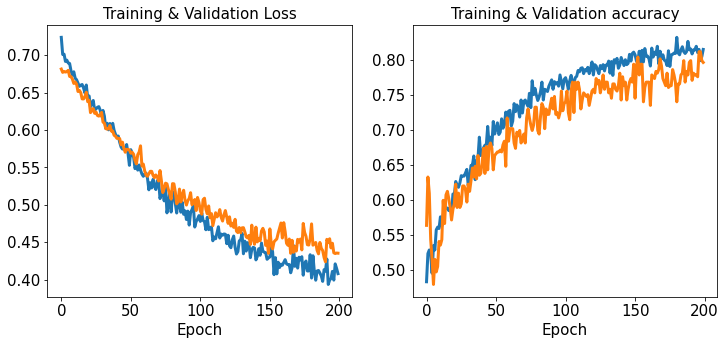

In [31]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 7.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394139 sha256=7987d49e5a28f43c4c286a806d09fde1e5b3c0d97d14124f9ecc3f27625473c0
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [33]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [34]:
shap_values  = explainer.shap_values(np.array(X_test_new))

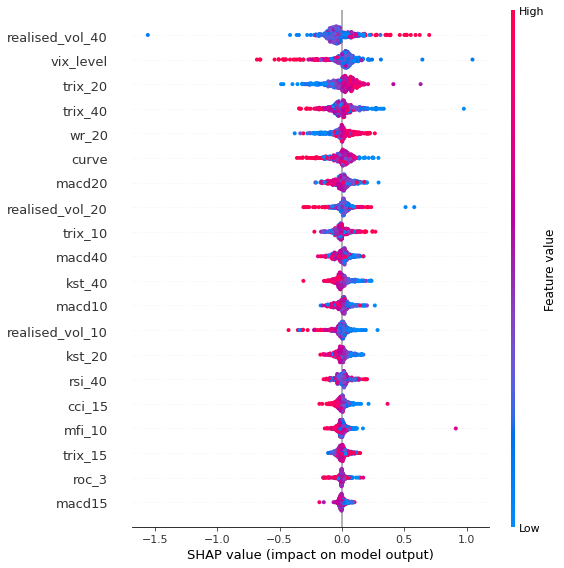

In [35]:
shap.summary_plot(shap_values[1], X_test_new)

In [36]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


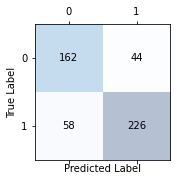

In [38]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [39]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.837
Recall: 0.796
F1: 0.816


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [42]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [43]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [10,20,30,40],
  }
]

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [46]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [47]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 27.0min finished


In [48]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/JPM/xgb_JPM_log_reg.pickle', "wb"))

In [49]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9268268206528971
Accuracy: 0.8714285714285714


Confusion Matrix


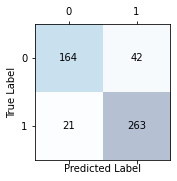

In [50]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [51]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7fedf81f00d0>}


In [52]:
model_opt = xgb.XGBClassifier(max_depth=7,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.0)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.327551	validation_0-logloss:0.678038	validation_1-error:0.373469	validation_1-logloss:0.683155
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.280612	validation_0-logloss:0.662083	validation_1-error:0.367347	validation_1-logloss:0.676304
[2]	validation_0-error:0.219898	validation_0-logloss:0.63668	validation_1-error:0.293878	validation_1-logloss:0.6567
[3]	validation_0-error:0.168878	validation_0-logloss:0.605041	validation_1-error:0.255102	validation_1-logloss:0.63242
[4]	validation_0-error:0.166837	validation_0-logloss:0.594798	validation_1-error:0.253061	validation_1-logloss:0.625442
[5]	validation_0-error:0.164286	validation_0-logloss:0.583002	validation_1-error:0.253061	validation_1-logloss:0.618685
[6]	validation_0-error:0.129082	validation_0-logloss:0.561732	validation_1-error:0.240816	validation_1-logloss:0.604131

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [53]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.31%


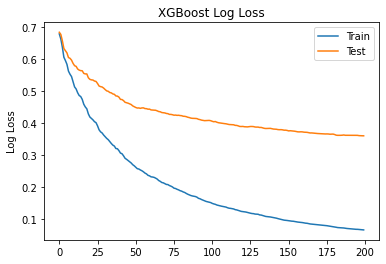

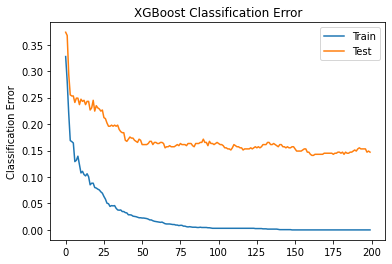

In [54]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [55]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


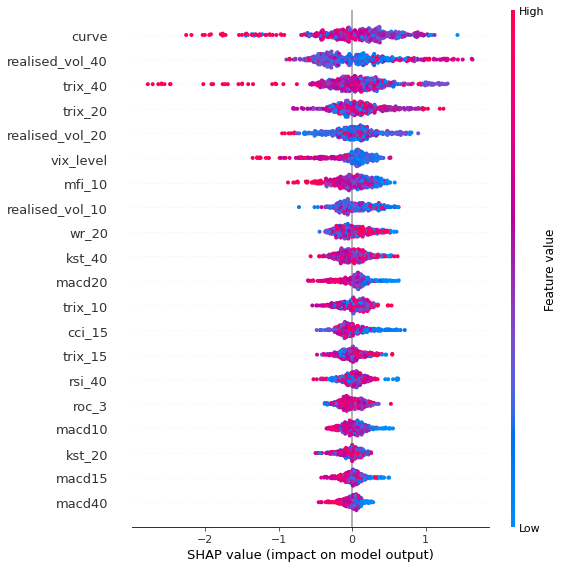

In [56]:
shap.summary_plot(shap_values, X_test_new)

In [57]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


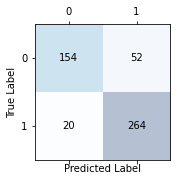

In [58]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()